In [ ]:
# ver si funciona para ver estado anterior del kernel
#import dill
#dill.load_session('notebook_env.db')


In [ ]:
import numpy as np
from scipy.special import gammaln
from collections import defaultdict 

# Sampler for seating arrangment

Sample $t$ according to 
\begin{equation*}
    p(t_{ji}=t \,|\, {\bf t}^{-ji}, {\bf k}) \propto
    \begin{cases}
        n_{jt\cdot}^{-ji}  \frac{\beta+n_{k_{jt}v}^{-ji}}{V\beta+n_{k_{jt}\cdot}^{-ji}}
        & { \text{if } t \text{ currently used}}\\
        {\small
            \alpha \,
            p(x_{ji} \,|\, {\bf t}^{-ji}, t_{ji}=t^{new}, {\bf k})}
        & { \text{if } t=t^{\text{new}}}
    \end{cases}
\end{equation*}
and for $t_{ji} =t^{\text{new}}$, sample a dish index $k_{jt^{\text{new}}}$ according to 
\begin{equation*}
\begin{aligned}
     p(k_{jt^\text{new}}=k \,|\, {\bf t}, {\bf k}^{-jt^\text{new}}) &\propto
    \begin{cases}
        m_{\cdot k}\frac{\beta+n_{kv}^{-ji}}{V\beta+n_{k\cdot}^{-ji}}
        & { \text{if } k \text{ currently used}}\\
        \frac{
           \gamma
        }{V}
        & { \text{if } k=k^{\text{new}}}
    \end{cases}
\end{aligned}
\end{equation*}
Finally, sample global topics according to
\begin{align*}
    p(k_{jt}=k \, | \, x_{ji}, \,  {\bf k}^{-jt}, {\bf t})
    &\propto
    \begin{cases}
        m_{\cdot k}^{-jt} \, \frac{
       \prod_w \Gamma\left(
           n_{kw}^{-jt} + n_{\cdot w}^{jt} + \beta
       \right)
    }{
            \prod_w \Gamma\left(
                n_{kw}^{-jt} + \beta
            \right)
        }
    \frac{
            \Gamma\left(
                n_{k\cdot}^{-jt}+V\beta
            \right)
        }{
      \Gamma \left(
        n_{k\cdot}^{-jt} + n_{\cdot \cdot}^{jt} + \beta
      \right)
    }
            & { \text{if } k \text{ currently used}}\\
        \gamma \, \frac{
        \Gamma(V\beta)
        \prod_w \Gamma(\beta+n_{\cdot w}^{jt})
    }{
        \Gamma(V\beta+n_{\cdot\cdot}^{jt})
        \prod_w \Gamma(\beta)
    }
            & { \text{if } k=k^{\text{new}}}
    \end{cases}
\end{align*}

In [ ]:
class HDPLDA:
    def __init__(self, alpha, beta, gamma, docs, V):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.V = V
        self.M = len(docs)

        # Mappings
        self.x_ji = docs # Integer representation of documents
        self.k_jt = [np.zeros(1, dtype=int) for j in range(self.M)]   # Nested array for mapping doc-table to dish 
        self.t_ji = [np.zeros(len(x_i), dtype=int) - 1 for x_i in docs]  # Nested array for mapping doc-word to table
                                                                         # -1 means no table assigned
        
        # Counts
        self.n_jt = [np.zeros(1, dtype=int) for j in range(self.M)]  # Nested array for counts of words assigned to doc-table 
        self.m = 0 # Total number of tables 
        self.m_k = np.ones(1 , dtype = int)  # Total number of tables assigned to each dish / topic
        self.n_k = np.array([self.beta*self.V]) #  Number of words assigned to each dish (+ beta*V)
        self.n_kv = [DefaultDict(0)]  #Number of times a given word is assigned to each dish (+beta)
        self.n_jtv = [[None] for j in range(self.M)]  # Nested array for counts for doc/table/word triplets 
        
        
        # Nested array giving list of indices of active table for each document
        #     t=0 means to draw a new table 
        self.active_tables = [[0] for j in range(self.M)] 

        # List of indices of active dishes
        self.active_dishes = [0]
        
        
        

    def iteration(self):
        # Seating arrangement array from each word
        for j, x_i in enumerate(self.x_ji):
            for i in range(len(x_i)):
                self.sample_tables(j, i)
        # Dish arrangement for active tables
        for j in range(self.M): 
            for t in self.active_tables[j]:
                if t != 0: self.sample_dishes(j, t)

                    
                    
    def sample_tables(self, j, i):
        # Checks if word x_ji leaves its table
        self.leave_table(j, i)

        v = self.x_ji[j][i]
        f_k = [n_kv[v] for n_kv in self.n_kv] / self.n_k
        
        assert f_k[0] == 0 
        # posterior p(t_ji=t)
        current_t = self.active_tables[j]
        p_t = self.n_jt[j][current_t] * f_k[self.k_jt[j][current_t]]
        p_x_ji = np.inner(self.m_k, f_k) + self.gamma / self.V
        p_t[0] = p_x_ji * self.alpha / (self.gamma + self.m)
        p_t /= p_t.sum()
        
        #if len(p_t) > 1 and p_t[1] < 0: self.dump()
        t_new = self.active_tables[j][np.random.multinomial(1, p_t).argmax()]
        
        if t_new == 0: # Word sits at a new table
            # posterior p(k_jt_new=k)
            p_k = self.dish_posterior_word(f_k)
            k_new = self.active_dishes[np.random.multinomial(1, p_k).argmax()]
            if k_new == 0: # Sample a completely new dish 
                k_new = self.add_dish()
            t_new = self.add_table(j, k_new)

        # increase counters
        self.seat_at_table(j, i, t_new)

        
    def leave_table(self, j, i):
        t = self.t_ji[j][i]
        if t  > 0:
            k = self.k_jt[j][t]
            assert k > 0

            #Decrease counters 
            v = self.x_ji[j][i]
            self.n_kv[k][v] -= 1 # minus one word v on dish served at that table
            self.n_k[k] -= 1 # minus one word on dish 
            self.n_jt[j][t] -= 1 # minus one word at that table 
            self.n_jtv[j][t][v] -= 1 # overall counter on triplets also decreases

            if self.n_jt[j][t] == 0: 
                # if table is empty delete it
                self.delete_table(j, t) 

    
    def delete_table(self, j, t):
        # Deletes table where all words are gone
        k = self.k_jt[j][t]
        self.active_tables[j].remove(t)
        
        # Decrease counters 
        self.m_k[k] -= 1 # one less table eating dish k
        self.m -= 1 # one less table overall
        assert self.m_k[k] >= 0
        
        if self.m_k[k] == 0:
            # if dish k is empty delete it
            self.active_dishes.remove(k)


    def seat_at_table(self, j, i, t_new):
        assert t_new in self.active_tables[j]
        self.t_ji[j][i] = t_new # word x_ji sits at table t_new
        self.n_jt[j][t_new] += 1 # one word at table t_new

        k_new = self.k_jt[j][t_new] # dish for new table
        self.n_k[k_new] += 1 # word appears on dish k_new
        v = self.x_ji[j][i]
        self.n_kv[k_new][v] += 1 # word v appears +1 on dish k_new
        self.n_jtv[j][t_new][v] += 1 

    
    def add_table(self, j, k_new):
        # Assign word x_ji to a new table and draw the dish 
        assert k_new in self.active_dishes
        for t_new, t in enumerate(self.active_tables[j]):
            # Checks if new table has already been used
            if t_new != t: break
        else:
            # If not, t_new = |tables|+1
            t_new = len(self.active_tables[j])
            # Reshape counters 
            self.n_jt[j].resize(t_new+1)
            self.k_jt[j].resize(t_new+1)
            self.n_jtv[j].append(None)
        
        #Insert new table to list of active tables and increase table counters
        self.active_tables[j].insert(t_new, t_new)
        self.n_jt[j][t_new] = 0  # to make sure
        self.n_jtv[j][t_new] = DefaultDict(0)
        self.k_jt[j][t_new] = k_new
        self.m_k[k_new] += 1
        self.m += 1
        return t_new

    
    def dish_posterior_word(self, f_k):
        # Dish posterior for the new table on which word x_ji sits
        p_k = (self.m_k * f_k)[self.active_dishes]
        p_k[0] = self.gamma / self.V
        return p_k / p_k.sum()


    def sample_dishes(self, j, t):
        # Checks if table t_jt leaves its dish
        self.leave_dish(j, t)

        # posterior p(k_jt=k)
        p_k = self.dish_posterior_table(j, t)
        k_new = self.active_dishes[np.random.multinomial(1, p_k).argmax()]
        if k_new == 0: # Sample a new dish 
            k_new = self.add_dish()
            
        self.seat_at_dish(j, t, k_new)

        
    def leave_dish(self, j, t):
        k = self.k_jt[j][t]
        assert k > 0
        assert self.m_k[k] > 0
        
        # Decrease table counters
        self.m_k[k] -= 1  # one less table for dish k
        self.m -= 1  # one less table overall
        if self.m_k[k] == 0: 
            # If dish k is empty delete it
            self.active_dishes.remove(k)
            self.k_jt[j][t] = 0

            
    def dish_posterior_table(self, j, t):
        # Dish posterior for the table 
        k_old = self.k_jt[j][t]     # it may be zero (means a removed dish)
        Vbeta = self.V * self.beta
        n_k = self.n_k.copy()
        n_jt = self.n_jt[j][t]
        n_k[k_old] -= n_jt
        n_k = n_k[self.active_dishes]
        log_p_k = np.log(self.m_k[self.active_dishes]) + gammaln(n_k) - gammaln(n_k + n_jt)
        log_p_k_new = np.log(self.gamma) + gammaln(Vbeta) - gammaln(Vbeta + n_jt)
        gammaln_beta = gammaln(self.beta)
        
        for w, n_jtw in self.n_jtv[j][t].items():
            assert n_jtw >= 0
            if n_jtw == 0: continue
            n_kw = np.array([n.get(w, self.beta) for n in self.n_kv])
            n_kw[k_old] -= n_jtw
            n_kw = n_kw[self.active_dishes]
            n_kw[0] = 1 # dummy for logarithm's warning
            if np.any(n_kw <= 0): print(n_kw) # for debug
            log_p_k += gammaln(n_kw + n_jtw) - gammaln(n_kw)
            log_p_k_new += gammaln(self.beta + n_jtw) - gammaln_beta
            
        log_p_k[0] = log_p_k_new
        p_k = np.exp(log_p_k - log_p_k.max())
        return p_k / p_k.sum()

    
    def seat_at_dish(self, j, t, k_new):
        # Increase counters 
        self.m += 1 # +1 table overall
        self.m_k[k_new] += 1 # +1 table for dish k

        k_old = self.k_jt[j][t]     # it may be zero (means a removed dish)
        if k_new != k_old:
            self.k_jt[j][t] = k_new
            n_jt = self.n_jt[j][t]
            if k_old != 0: self.n_k[k_old] -= n_jt
            self.n_k[k_new] += n_jt
            for v, n in self.n_jtv[j][t].items():
                if k_old != 0: self.n_kv[k_old][v] -= n
                self.n_kv[k_new][v] += n


    def add_dish(self):
        for k_new, k in enumerate(self.active_dishes):
            # Checks if new dish has already been used
            if k_new != k: break
        else:
            # If not, then k_new = |dishes|+1 
            k_new = len(self.active_dishes)
            if k_new >= len(self.n_kv):
                # Reshape counters 
                self.n_k = np.resize(self.n_k, k_new + 1)
                self.m_k = np.resize(self.m_k, k_new + 1)
                self.n_kv.append(None)
            #Check if correct assignment
            assert k_new == self.active_dishes[-1] + 1
            assert k_new < len(self.n_kv)
            
        #Insert new dish to list of used dishes
        self.active_dishes.insert(k_new, k_new)
        self.n_k[k_new] = self.beta * self.V
        self.m_k[k_new] = 0
        self.n_kv[k_new] = DefaultDict(self.beta)
        return k_new
    
    
    def docdist(self):
        theta = []
        for j, n_jt in enumerate(self.n_jt):
            p_jk = np.zeros(len(self.m_k), dtype = float)
            for t in self.active_tables[j]:
                if t == 0: continue
                k = self.k_jt[j][t]
                p_jk[k] += n_jt[t]
            theta.append(p_jk / p_jk.sum())
        return np.array(theta)
    

    def worddist(self):
        return [DefaultDict(0).update(
            (v, n_kv / self.n_k[k]) for v, n_kv in self.n_kv[k].items())
                for k in self.active_dishes if k != 0]
    
    
    
    
    def perplexity(self):
        phi = [DefaultDict(1.0/self.V)] + self.worddist()
        theta = self.docdist()
        log_likelihood = 0
        N = 0
        for x_ji, p_jk in zip(self.x_ji, theta):
            for v in x_ji:
                word_prob = sum(p*p_kv[v] for p, p_kv in zip(p_jk, phi))
                log_likelihood -= np.log(word_prob)
                N += len(x_ji)
        return np.exp(log_likelihood/N)


In [ ]:
def sim(hdplda, burn, sample, step_size):
    if burn > 0:
        print("Burning-in")
        for i in range(burn):
            hdplda.iteration()
    print("\nSampling")
    for j in range(sample):
        hdplda.iteration()
        if step_size!= 0 and j%step_size ==0:
            print("\nIteration:", (j + 1), "Perplexity:", hdplda.perplexity(), "Num topics:", len(hdplda.active_dishes)-1)
    return hdplda

In [ ]:
def summary(hdplda, voca, fp = None):
    phi = hdplda.worddist()
    for k, phi_k in enumerate(phi):
        print("\nTopic {top} has {words} word components".format(top=k, words=len(phi[k])))
        for w in sorted(phi_k, key = lambda w:-phi_k[w])[:6]:
            print(voca[w], ": %.3f" %phi_k[w])
    
    theta = hdplda.docdist()
    print("\n- - - - Document topic distribution - - - - - -")
    for j, theta_j in enumerate(theta):
        print("%d \t %s \n" % (j,"\t".join("%.3f" % p for p in theta_j[1:])))
    
    print("\n- - - - Dishes per document - - - - - -")
    for j, active_tables in enumerate(hdplda.active_tables):
        print("%d \t %s \n" % (j, "\t".join(str(hdplda.k_jt[j][t]) for t in active_tables if t>0)))

## Pre process

In [6]:
import re
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim.corpora as corpora

stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        #deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[nltk.stem.WordNetLemmatizer().lemmatize(word) for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [7]:
content = pd.read_pickle('content.pkl')
raw_poems = []

for p in content.poem.map(int).unique():
    flat_poem = ' '.join([text for text in content.loc[content.poem == p, 'text']])
    raw_poems.append(flat_poem)


In [8]:
corpus = list(sent_to_words(raw_poems))
corpus = remove_stopwords(corpus)

In [9]:
# Create vocabulary
vocabulary = corpora.Dictionary(corpus)

# Integer representation of documents
docs = [vocabulary.doc2idx(text) for text in corpus] 

In [13]:
small_corpus = corpus[:15]
small_voc = corpora.Dictionary(small_corpus)
small_docs = [small_voc.doc2idx(text) for text in small_corpus] 

In [11]:
print("V: ", len(vocabulary))
print("\nSmall V: ", len(small_voc))

V:  12057

Small V:  906


In [12]:
print("Total number of poems: ", len(docs))

Total number of poems:  1363


# Toy example

In [47]:
print("Original poem: ", corpus[4])
print("\nInteger rep: ", docs[4])

Original poem:  ['awakened', 'dryness', 'fern', 'dead', 'potted', 'plant', 'yellow', 'corn', 'woman', 'gone', 'empty', 'bottle', 'like', 'bled', 'corps', 'surrounded', 'uselessness', 'sun', 'still', 'good', 'though', 'landlady', 'note', 'cracked', 'fine', 'undemanding', 'yellowness', 'needed', 'good', 'comedian', 'ancient', 'style', 'jester', 'joke', 'upon', 'absurd', 'pain', 'pain', 'absurd', 'exists', 'nothing', 'shaved', 'carefully', 'old', 'razor', 'man', 'young', 'said', 'genius', 'tragedy', 'leaf', 'dead', 'fern', 'dead', 'plant', 'walked', 'dark', 'hall', 'landlady', 'stood', 'execrating', 'final', 'sending', 'hell', 'waving', 'fat', 'sweaty', 'arm', 'screaming', 'screaming', 'rent', 'world', 'failed', 'u']

Integer rep:  [3, 13, 19, 12, 39, 38, 62, 8, 60, 23, 14, 5, 31, 4, 9, 50, 57, 49, 46, 24, 52, 29, 34, 10, 21, 55, 63, 33, 24, 7, 1, 48, 27, 28, 56, 0, 37, 37, 0, 16, 35, 45, 6, 36, 40, 32, 64, 42, 22, 53, 30, 12, 19, 12, 38, 58, 11, 25, 29, 47, 15, 20, 44, 26, 59, 18, 51, 2,

In [ ]:
print("\nSecond word is: ", vocabulary[13])

In [ ]:
alpha = 1
beta = 0.5
gamma = 1

np.random.seed(369)
small_model = HDPLDA(alpha, beta, gamma, small_docs, len(small_voc))

In [ ]:
sim(small_model, 20, 50, 0)

In [ ]:
summary(small_model, small_voc)

In [ ]:
small_model.active_tables

In [ ]:
small_model.t_ji

In [ ]:
small_model.k_jt

In [ ]:
small_model.active_dishes

## Whole dataset

In [16]:
alpha = 1
beta = 0.5
gamma = 1

model = HDPLDA(alpha, beta, gamma, docs, len(vocabulary))

In [18]:
%%time
burn = 50
sample = 250
step_size = 0

lda = sim(model, burn, sample, step_size)

Burning-in

Sampling
Wall time: 2h 8min 22s


In [26]:
summary(model, vocabulary)


Topic 1 has 12017 word components
like : 0.01648
love : 0.00588
dead : 0.00516
men : 0.00472
sun : 0.00436
fire : 0.00417

Topic 2 has 12057 word components
one : 0.01029
said : 0.01008
like : 0.00948
back : 0.00728
got : 0.00719
get : 0.00669

Topic 3 has 11593 word components
joe : 0.00336
foch : 0.00133
porsche : 0.00101
kaakaa : 0.00101
driven : 0.00086
brien : 0.00070

Topic 4 has 4862 word components
lurks : 0.00214
bottom : 0.00150
engage : 0.00071
pm : 0.00055
minnow : 0.00040
schopenhauer : 0.00040

Topic 5 has 11631 word components
mr : 0.00370
max : 0.00188
christmas : 0.00146
gredis : 0.00132
camel : 0.00119
cagney : 0.00119

Topic 6 has 5971 word components
miriam : 0.00102
cord : 0.00071
critter : 0.00055
oklahoma : 0.00055
petty : 0.00039
cryin : 0.00039

Topic 7 has 2228 word components
charutos : 0.00074
pimentel : 0.00058
dwight : 0.00058
numbo : 0.00041
babe : 0.00025
crawl : 0.00025

Topic 8 has 6785 word components
louie : 0.00074
brutalized : 0.00074
hodges : 0.0

1332 	 0.50124	0.49821	0.00004	0.00002	0.00008	0.00003	0.00000	0.00000	0.00004	0.00001	0.00000	0.00002	0.00005	0.00008	0.00000	0.00000	0.00004	0.00003	0.00001	0.00002	0.00003	0.00001	0.00000	0.00001	0.00003	0.00001 

1333 	 0.70980	0.28891	0.00010	0.00005	0.00019	0.00006	0.00001	0.00000	0.00009	0.00002	0.00001	0.00005	0.00011	0.00018	0.00001	0.00000	0.00009	0.00006	0.00002	0.00004	0.00006	0.00003	0.00000	0.00001	0.00006	0.00001 

1334 	 0.60336	0.39514	0.00011	0.00005	0.00023	0.00007	0.00001	0.00001	0.00011	0.00002	0.00001	0.00006	0.00013	0.00021	0.00001	0.00001	0.00010	0.00007	0.00003	0.00005	0.00007	0.00003	0.00000	0.00002	0.00007	0.00001 

1335 	 0.01374	0.87949	0.00007	0.00003	0.00013	0.00004	0.00001	0.00000	0.10595	0.00001	0.00001	0.00004	0.00008	0.00012	0.00000	0.00000	0.00006	0.00004	0.00002	0.00003	0.00004	0.00002	0.00000	0.00001	0.00004	0.00001 

1336 	 0.12251	0.87659	0.00007	0.00003	0.00014	0.00004	0.00001	0.00000	0.00007	0.00001	0.00001	0.00004	0.00008	0.00013	0.00001	0.000

425 	 2	2	2	2	2	2	1	20	2 

426 	 2	1	2 

427 	 2	2	2	2	2 

428 	 2	2	2	2	2	2 

429 	 2	2	2 

430 	 2	2	2	2	2	2 

431 	 2	2	2	2	2	2	13 

432 	 1	15	2	2 

433 	 2	2	2	2	1	24 

434 	 14	2	2	1 

435 	 2	2	2	2	1 

436 	 2	2	2	2	2 

437 	 3	2 

438 	 2	2	20	1 

439 	 2	2	2	13 

440 	 1	2	2	2 

441 	 2	2	2	1	2	2	2 

442 	 2	2	2	2 

443 	 2	2	13	2 

444 	 1	20	2	2	2 

445 	 1	2 

446 	 2	2	2	2 

447 	 2	2	2	2	2 

448 	 2	2	1 

449 	 2	2	5	2 

450 	 2	6	2	2	2 

451 	 2	2	1 

452 	 2	2	1	2	2	1 

453 	 2	1	2	2	5	2	2	2 

454 	 2	1	2	2	14 

455 	 15	1	2 

456 	 1	2	2 

457 	 2	2	2	2	2	1 

458 	 2	15	1	2	2	2	2	2 

459 	 2	2	2	2	2	2	2 

460 	 2	2	15	2	2	2 

461 	 2	2	2	2	2 

462 	 2	2	2 

463 	 2	2	2	2	5 

464 	 2	2	2	2	2	2 

465 	 2	2	1	1	2	2 

466 	 2	2	2 

467 	 2	2	4	2 

468 	 2	2 

469 	 2	1	29	13	2	2 

470 	 2	2	1	1	2 

471 	 2	2	2	2	2	2	13	2 

472 	 2	2	2 

473 	 2	2	2	2 

474 	 2	2	2	1	2 

475 	 2	2	2	2 

476 	 2	2	2	2	19	2	9 

477 	 1	2	2 

478 	 15	2	2	2	2	2 

479 	 2	2	2	2	2 

480 	 2	2	2 

## Plots

In [19]:
import warnings
warnings.filterwarnings('ignore')


In [20]:
m = model.perplexity()
print(m)

topic_term = pd.DataFrame(model.worddist()).fillna(0).to_numpy() 
doc_topic= pd.DataFrame(model.docdist()).fillna(0).to_numpy()[:,1:] 
doc_lengths = [len(d) for d in docs]
word_freq = [sum(x.count(a) for x in docs) for a in range(len(vocabulary))]

1.042673842184292


In [48]:
import pyLDAvis
vis = pyLDAvis.prepare(topic_term/topic_term.sum(axis=1)[:, None], 
                       doc_topic/doc_topic.sum(axis=1)[:, None], 
                       doc_lengths, # ndocs
                       vocabulary,
                       word_freq)

pyLDAvis.display(vis)

# Comparison with LDA

In [21]:
m = model.perplexity()
print(m)

1.042673842184292


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")

In [23]:
docs_lda = [vocabulary.doc2bow(text) for text in corpus]
num_topics = np.arange(15, 65, 5)
perp = []

for k in num_topics:
    model_LDA = gensim.models.LdaMulticore(corpus=docs_lda, id2word=vocabulary, num_topics=k, iterations = 400)
    perp.append(model_LDA.log_perplexity(docs_lda))
    
perplexity_LDA = [np.exp(-lp) for lp in perp]

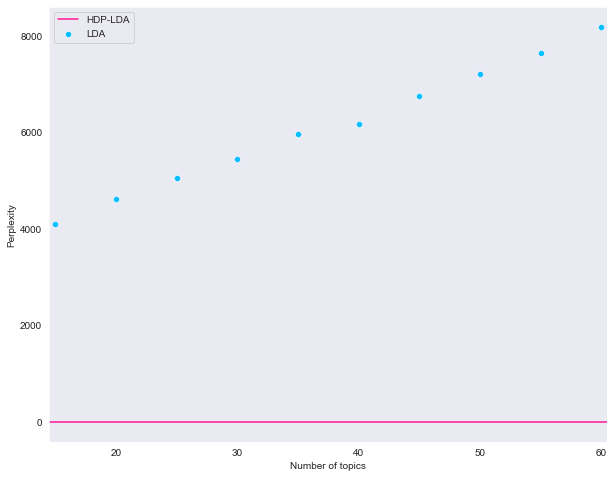

In [24]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.scatterplot(num_topics, perplexity_LDA, color = 'deepskyblue', label ='LDA')
ax.axhline(m, color = 'deeppink', label='HDP-LDA')
ax.set_xlim(14.5, 60.5)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.legend()

In [49]:
import dill
dill.dump_session('notebook_env.db')

C:\Users\viole\.julia\conda\3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class DefaultDict(dict):
    def __init__(self, v):
        self.v = v
        dict.__init__(self)
        
    def __getitem__(self, k):
        return dict.__getitem__(self, k) if k in self else self.v
    
    def update(self, d):
        dict.update(self, d)
        return self